<a href="https://colab.research.google.com/github/MSIMulti/AIFFEL_quest_cr/blob/master/MainQuest/Quest07/MainQuest07.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [50]:
# 필요 라이브러리 로딩
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, losses, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from PIL import Image

print(tf.__version__)

2.17.1


In [51]:
# Hyperparameters
image_size = 256
img_shape = (image_size, image_size, 3)
batch_size = 8
max_epochs = 10

In [32]:
!unzip /content/drive/MyDrive/AIFFEL/aiffel/main_quest_7/ed_ckpt.zip -d /content/drive/MyDrive/AIFFEL/aiffel/main_quest_7/ed_ckpt
!unzip /content/drive/MyDrive/AIFFEL/aiffel/main_quest_7/train.zip -d /content/drive/MyDrive/AIFFEL/aiffel/main_quest_7/train
!unzip /content/drive/MyDrive/AIFFEL/aiffel/main_quest_7/train_ckpt.zip -d /content/drive/MyDrive/AIFFEL/aiffel/main_quest_7/train_ckpt
!unzip /content/drive/MyDrive/AIFFEL/aiffel/main_quest_7/train_labels.zip -d /content/drive/MyDrive/AIFFEL/aiffel/main_quest_7/labels
!unzip /content/drive/MyDrive/AIFFEL/aiffel/main_quest_7/unet_ckpt.zip -d /content/drive/MyDrive/AIFFEL/aiffel/main_quest_7/unet_ckpt

Archive:  /content/drive/MyDrive/AIFFEL/aiffel/main_quest_7/ed_ckpt.zip
  inflating: /content/drive/MyDrive/AIFFEL/aiffel/main_quest_7/ed_ckpt/checkpoint  
  inflating: /content/drive/MyDrive/AIFFEL/aiffel/main_quest_7/ed_ckpt/ed_model.data-00000-of-00001  
  inflating: /content/drive/MyDrive/AIFFEL/aiffel/main_quest_7/ed_ckpt/ed_model.index  
Archive:  /content/drive/MyDrive/AIFFEL/aiffel/main_quest_7/train.zip
  inflating: /content/drive/MyDrive/AIFFEL/aiffel/main_quest_7/train/1.bmp  
  inflating: /content/drive/MyDrive/AIFFEL/aiffel/main_quest_7/train/10.bmp  
  inflating: /content/drive/MyDrive/AIFFEL/aiffel/main_quest_7/train/100.bmp  
  inflating: /content/drive/MyDrive/AIFFEL/aiffel/main_quest_7/train/101.bmp  
  inflating: /content/drive/MyDrive/AIFFEL/aiffel/main_quest_7/train/102.bmp  
  inflating: /content/drive/MyDrive/AIFFEL/aiffel/main_quest_7/train/103.bmp  
  inflating: /content/drive/MyDrive/AIFFEL/aiffel/main_quest_7/train/104.bmp  
  inflating: /content/drive/MyDriv

In [52]:
# 데이터 준비
DATASET_PATH = '/content/drive/MyDrive/AIFFEL/aiffel/main_quest_7'
img_dir = os.path.join(DATASET_PATH, "train")
label_dir = os.path.join(DATASET_PATH, "labels")
if not os.listdir(img_dir):
    raise FileNotFoundError(f"No files found in train directory: {img_dir}")
x_train_filenames = [os.path.join(img_dir, f) for f in os.listdir(img_dir)]
if not os.listdir(label_dir):
    raise FileNotFoundError(f"No files found in labels directory: {label_dir}")
y_train_filenames = [os.path.join(label_dir, f) for f in os.listdir(label_dir)]
x_train_filenames, x_test_filenames, y_train_filenames, y_test_filenames = train_test_split(
    x_train_filenames, y_train_filenames, test_size=0.2
)
num_train_examples = len(x_train_filenames)
num_test_examples = len(x_test_filenames)

print("Number of training examples:", num_train_examples)
print("Number of test examples:", num_test_examples)

Number of training examples: 240
Number of test examples: 60


In [53]:
# 데이터 전처리 함수
def _process_pathnames(fname, label_path):
    img_str = tf.io.read_file(fname)
    img = tf.image.decode_bmp(img_str, channels=3)

    label_img_str = tf.io.read_file(label_path)
    label_img = tf.image.decode_bmp(label_img_str, channels=3)
    label_img = tf.image.rgb_to_grayscale(label_img)

    resize = [image_size, image_size]
    img = tf.image.resize(img, resize)
    label_img = tf.image.resize(label_img, resize)

    scale = 1 / 255.0
    img = tf.cast(img, dtype=tf.float32) * scale
    label_img = tf.cast(label_img, dtype=tf.float32) * scale

    return img, label_img

In [54]:
# 데이터 증강 함수
def _augment(img, label_img):
    img = tf.image.random_flip_left_right(img)
    label_img = tf.image.random_flip_left_right(label_img)
    img = tf.image.random_brightness(img, max_delta=0.1)
    img = tf.image.random_contrast(img, 0.8, 1.2)

    return img, label_img

In [55]:
# tf.data.Dataset 구성
def get_dataset(filenames, labels, augment=False):
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    dataset = dataset.map(_process_pathnames, num_parallel_calls=tf.data.AUTOTUNE)
    if augment:
        dataset = dataset.map(_augment, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(buffer_size=len(filenames))
    dataset = dataset.batch(batch_size)
    return dataset

train_dataset = get_dataset(x_train_filenames, y_train_filenames, augment=True)
test_dataset = get_dataset(x_test_filenames, y_test_filenames)

In [60]:
# U-Net 모델 정의
class UNet(tf.keras.Model):
    def __init__(self):
        super(UNet, self).__init__()
        self.encoder1 = self.conv_block(64)
        self.encoder2 = self.conv_block(128)
        self.encoder3 = self.conv_block(256)
        self.encoder4 = self.conv_block(512)

        self.center = self.conv_block(1024)

        self.decoder4 = self.deconv_block(512)
        self.decoder3 = self.deconv_block(256)
        self.decoder2 = self.deconv_block(128)
        self.decoder1 = self.deconv_block(64)

        self.output_conv = layers.Conv2D(1, (1, 1), activation='sigmoid')

    def conv_block(self, filters):
        block = models.Sequential([
            layers.Conv2D(filters, (3, 3), padding='same'),
            layers.BatchNormalization(),
            layers.ReLU(),
            layers.Conv2D(filters, (3, 3), padding='same'),
            layers.BatchNormalization(),
            layers.ReLU(),
        ])
        return block

    def deconv_block(self, filters):
        block = models.Sequential([
            layers.Conv2DTranspose(filters, (3, 3), strides=2, padding='same'),
            layers.BatchNormalization(),
            layers.ReLU(),
        ])
        return block

    def call(self, inputs):
        enc1 = self.encoder1(inputs)
        enc2 = self.encoder2(layers.MaxPool2D((2, 2))(enc1))
        enc3 = self.encoder3(layers.MaxPool2D((2, 2))(enc2))
        enc4 = self.encoder4(layers.MaxPool2D((2, 2))(enc3))

        center = self.center(layers.MaxPool2D((2, 2))(enc4))

        dec4 = self.decoder4(tf.concat([center, tf.image.resize(enc4, center.shape[1:3])], axis=-1))
        dec3 = self.decoder3(tf.concat([dec4, tf.image.resize(enc3, dec4.shape[1:3])], axis=-1))
        dec2 = self.decoder2(tf.concat([dec3, tf.image.resize(enc2, dec3.shape[1:3])], axis=-1))
        dec1 = self.decoder1(tf.concat([dec2, tf.image.resize(enc1, dec2.shape[1:3])], axis=-1))

        outputs = self.output_conv(dec1)
        return outputs

In [61]:
# 모델 컴파일 및 학습
model = UNet()
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=losses.BinaryCrossentropy(),
              metrics=['accuracy'])

history = model.fit(train_dataset,
                    epochs=max_epochs,
                    validation_data=test_dataset,
                    callbacks=[
                        tf.keras.callbacks.ModelCheckpoint('unet_model.keras', save_best_only=True),
                        tf.keras.callbacks.EarlyStopping(patience=3)
                    ])

Epoch 1/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 72s 699ms/step - accuracy: 0.8757 - loss: 0.4912 - val_accuracy: 0.9430 - val_loss: 0.1998
Epoch 2/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 15s 385ms/step - accuracy: 0.9485 - loss: 0.2016 - val_accuracy: 0.9430 - val_loss: 0.2030
Epoch 3/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 402ms/step - accuracy: 0.9459 - loss: 0.2114 - val_accuracy: 0.9430 - val_loss: 0.1952
Epoch 4/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 410ms/step - accuracy: 0.9489 - loss: 0.1875 - val_accuracy: 0.9430 - val_loss: 0.1859
Epoch 5/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 401ms/step - accuracy: 0.9491 - loss: 0.1836 - val_accuracy: 0.9430 - val_loss: 0.1858
Epoch 6/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 14s 340ms/step - accuracy: 0.9509 - loss: 0.1751 - val_accuracy: 0.9430 - val_loss: 0.1862
Epoch 7/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 356ms/step - accuracy: 0.9507 - loss: 0.1771 - val_accuracy: 0.9430 - val_loss: 0.1864
Epoch 8/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 26s 536ms/step - accuracy: 0.9519 - loss: 0.1735 - val_accu

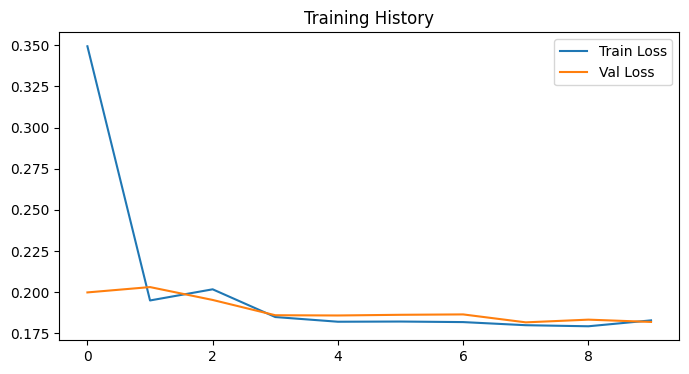

In [62]:
# 성능 시각화
def plot_history(history):
    plt.figure(figsize=(8, 4))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.legend()
    plt.title('Training History')
    plt.show()

plot_history(history)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


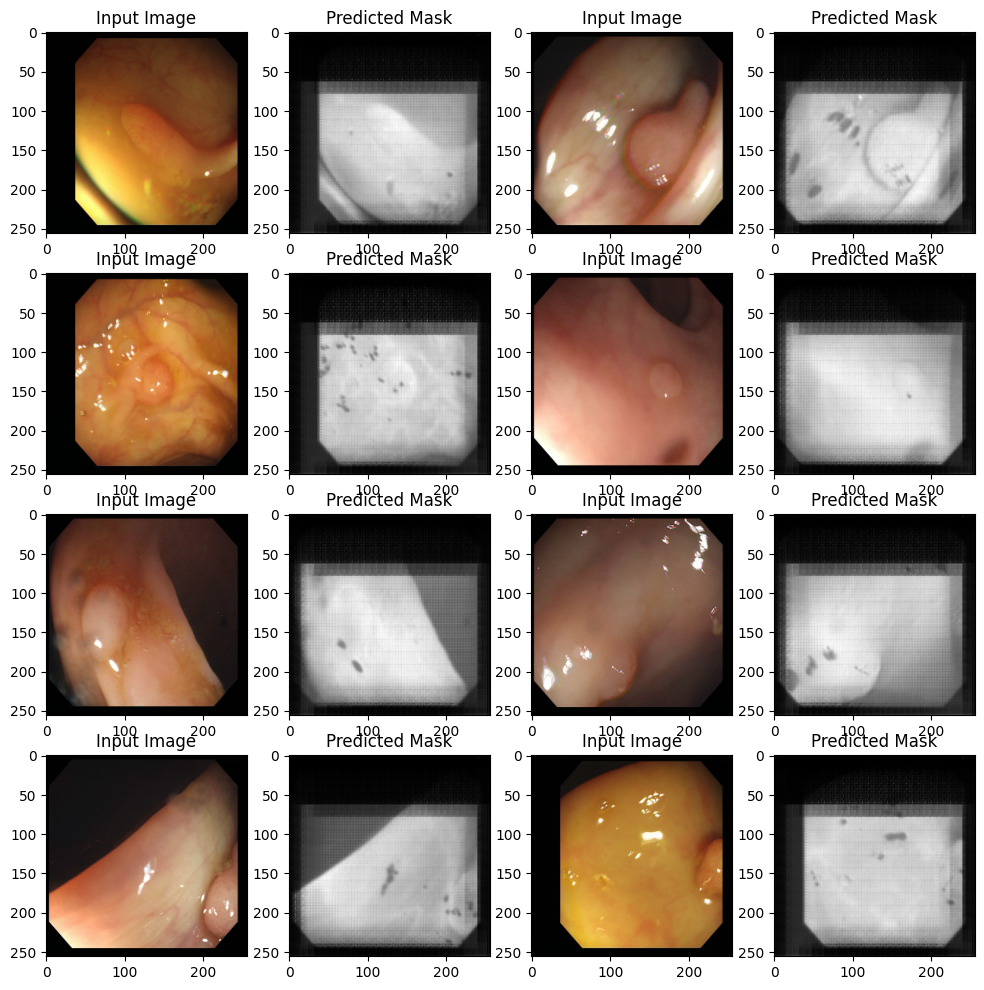

In [63]:
# 모델 평가
def evaluate_model():
    for images, labels in test_dataset.take(1):
        predictions = model.predict(images)

        plt.figure(figsize=(12, 12))
        for i in range(batch_size):
            plt.subplot(batch_size // 2, 4, i * 2 + 1)
            plt.imshow(images[i])
            plt.title('Input Image')

            plt.subplot(batch_size // 2, 4, i * 2 + 2)
            plt.imshow(predictions[i, :, :, 0], cmap='gray')
            plt.title('Predicted Mask')

        plt.show()

evaluate_model()